In [12]:
import pandas
import geopandas
import matplotlib.pyplot as plt
from fuzzywuzzy import process

In [210]:
df = pandas.read_csv("./GA_precincts_with_absentee.csv")

In [211]:
gdf = geopandas.read_file("./shapefiles/GA_precincts16.shp")

In [212]:
def search_for_match(precinct, county, gdf=gdf, column="PRECINCT_N"):
    choices = gdf[gdf["CTYNAME"] == county][column]
    name, rating, index = process.extractOne(precinct, choices)
    return {"county": county, "precinct": precinct, "rating": rating, "match_index": index}

In [213]:
def find_matches(df, gdf, column="PRECINCT_N"):
    assert set(df["COUNTY"]) == set(gdf["CTYNAME"])
    counties = df["COUNTY"].unique()
    records = [
        search_for_match(precinct, county, gdf=gdf, column=column)
        for county in counties
        for precinct in df[df["COUNTY"] == county]["PRECINCT"]
    ]
    matches = pandas.DataFrame.from_records(records)
    matches["match_value"] = matches["match_index"].map(gdf[column])
    return matches
counties = df["COUNTY"].unique()

In [214]:
matches = find_matches(df, gdf)

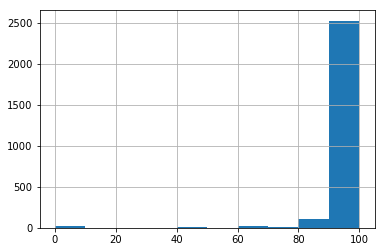

In [215]:
matches.rating.hist()

In [216]:
len(df) - len(gdf)

28

## The problem counties

### Counties with bad match scores:

- Bacon
- Bleckley ✅
- Chatham
- Chattahoochee
- Clarke
- Crawford ✅
- Rockdale
- Spalding ⚠️
- Taylor

### Counties with different numbers of precincts:

- Bibb 1 ✅
- Chattooga 1
- Columbia 3
- Crawford 3 ✅
- DeKalb 3
- Effingham 2
- Fayette 2
- Forsyth 4
- Fulton 1
- Gwinnett 1
- Henry 1 ✅
- Lowndes 2
- Muscogee 2
- Newton 2
- Pickens 1 ✅

### Counties with the wrong vote totals

- Bacon              89
- Barrow          -1501
- Chattahoochee    -567
- Chatham ✅ (added spaces to `txt` file)
- Columbia         -666
- DeKalb ✅ (added spaces to `txt` file)
- Douglas          -408
- Morgan            298

In [48]:
for county in counties:
    difference = len(df[df["COUNTY"] == county]) - len(gdf[gdf["CTYNAME"] == county])
    if difference > 0:
        print(county, difference)

Bibb 1
Chattooga 1
Columbia 3
Crawford 3
DeKalb 3
Effingham 2
Fayette 2
Forsyth 4
Fulton 1
Gwinnett 1
Henry 1
Lowndes 2
Muscogee 2
Newton 2
Pickens 1


In [49]:
average_by_county = matches.groupby("county").rating.mean()
average_by_county[average_by_county < 90]

county
Bacon            42.750000
Bleckley          0.000000
Chatham          87.134831
Chattahoochee    86.000000
Clarke           76.500000
Crawford         54.555556
Rockdale         82.777778
Spalding          0.000000
Taylor           56.000000
Name: rating, dtype: float64

### Crawford

In [24]:
crawford = df[df["COUNTY"] == "Crawford"]
crawford_gdf = gdf[gdf["CTYNAME"] == "Crawford"]

In [75]:
crawford_gdf.columns

Index(['ID', 'POPULATION', 'DISTRICT', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'FIPS1', 'FIPS2', 'PRES16D', 'PRES16R', 'PRES16L', 'SEN16D', 'SEN16R',
       'SEN16L', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'CONDIST', 'HDIST', 'SENDIST', 'geometry'],
      dtype='object')

In [74]:
crawford.columns

Index(['COUNTY', 'PRECINCT', 'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
       'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
       'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
       'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'],
      dtype='object')

In [25]:
columns_to_aggregate = [
    'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
    'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
    'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
    'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'
]

It looks like the shapefile has merged the "COUNTY" and "CITY" parts of each of precincts 1B, 2, and 3 into singular precincts 1B, 2, and 3.

In [77]:
merged_crawford_precincts = crawford.groupby(crawford["PRECINCT"].apply(lambda s: s.split()[0])).sum()
merged_crawford_precincts

,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
PRECINCT,,,,,,,,,,,,,,,,
1A,135,9,45,81,0,3,0,1,2,0,154,3,66,84,1,377
1B,389,29,152,207,1,10,1,4,5,0,225,8,125,92,0,813
2,507,32,334,141,0,24,0,16,8,0,548,39,377,132,0,1385
3,154,7,87,59,1,31,3,9,19,0,875,36,514,325,0,1331
4,126,11,61,54,0,16,0,7,9,0,906,36,398,471,1,1318
5,110,7,47,56,0,22,0,11,11,0,927,31,384,511,1,1301


In [27]:
merged_crawford_precincts.reset_index(inplace=True)
merged_crawford_precincts["COUNTY"] = "Crawford"

In [28]:
assert set(merged_crawford_precincts.columns) == set(df.columns)

In [29]:
merged_crawford_precincts.to_csv("./merged/crawford.csv", index=False)

### Bleckley

In [30]:
df[df["COUNTY"] == "Bleckley"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
127,Bleckley,FAIRGROUND,1101,113,502,479,7,123,1,66,56,0,3719,136,2076,1505,2,6162


In [31]:
gdf[gdf["CTYNAME"] == "Bleckley"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
878,1754047,13063,0231,1,1,Bleckley,13023,023,1101,3719,...,2655,7,87,3,0,49,008,144,020,"POLYGON ((-83.337441 32.530466, -83.337288 32...."


This one is just a single precinct in both datasets, and the vote totals match, so I feel good about matching it.

### Spalding

In [32]:
df[df["COUNTY"] == "Spalding"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
2400,Spalding,SECOND BAPTISH CH,741,27,336,376,2,8,0,3,5,0,101,5,59,37,0,1582
2401,Spalding,FAIRMONT,855,57,414,384,0,11,0,5,6,0,72,3,46,23,0,1588
2402,Spalding,SENIOR CENTER,192,20,120,52,0,39,3,22,14,0,740,39,544,157,0,1254
2403,Spalding,THIRD WARD,180,10,100,70,0,38,1,14,23,0,634,33,397,204,0,1083
2404,Spalding,UGA CAMPUS,975,24,528,422,1,56,2,34,20,0,831,46,589,196,0,2939
2405,Spalding,CITY PARK,839,36,447,356,0,15,0,11,4,0,221,18,141,62,0,1762
2406,Spalding,FIRST METHODIST,227,12,139,76,0,42,3,10,29,0,883,34,588,261,0,1377
2407,Spalding,BOY SCOUTS HDQTRS,267,10,154,103,0,25,4,12,9,0,867,28,600,239,0,1432
2408,Spalding,CABIN,151,3,101,47,0,25,1,12,12,0,927,30,505,391,1,1419
2409,Spalding,CARVER,380,11,203,164,2,27,1,16,10,0,796,32,511,253,0,1500


In [33]:
gdf[gdf["CTYNAME"] == "Spalding"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
165,1054638,3210,25514,14,19,Spalding,13255,255,235,722,...,316,7,8,0,3,8,003,073,016,"POLYGON ((-84.247136 33.338347, -84.247125 33...."
595,1089620,2656,25509,09,04,Spalding,13255,255,151,927,...,132,5,10,0,1,24,003,130,016,"POLYGON ((-84.08899099999999 33.285646, -84.08..."
598,816003,829,25515,15,02,Spalding,13255,255,44,368,...,9,3,2,0,0,2,003,073,016,"POLYGON ((-84.50851299999999 33.239846, -84.50..."
610,989093,2143,25512,12,15,Spalding,13255,255,177,766,...,160,3,7,0,0,11,003,073,016,"POLYGON ((-84.437512 33.208678, -84.442915 33...."
611,989165,3714,25519,19,11,Spalding,13255,255,405,1248,...,426,11,26,0,1,23,003,073,016,"(POLYGON ((-84.419723 33.289229, -84.419655000..."
654,1015373,1822,25503,03,18,Spalding,13255,255,192,740,...,106,2,13,0,0,9,003,130,016,"POLYGON ((-84.244934 33.229792, -84.2449309999..."
655,1015495,3276,25502,02,10,Spalding,13255,255,855,72,...,2000,7,3,4,0,17,003,130,016,"POLYGON ((-84.243694 33.248529, -84.243719 33...."
656,1015584,2322,25518,18,07,Spalding,13255,255,759,123,...,1263,6,0,5,0,21,003,073,016,"POLYGON ((-84.253989 33.303513, -84.247848 33...."
657,1015655,3019,25517,17,01,Spalding,13255,255,347,672,...,508,6,3,3,0,25,003,130,016,"(POLYGON ((-84.22183200000001 33.234187, -84.2..."
658,1063865,3170,25521,21,09,Spalding,13255,255,931,1720,...,399,6,9,1,1,18,003,130,016,"POLYGON ((-84.136798 33.308318, -84.1366419999..."


This one is wild! I suppose our next course of action is try and figure out where these landmarks ("SENIOR CENTER", "CITY PARK") are and then match that to our precinct geometries. We could also talk to the county for more information.

### Bacon

In [34]:
df[df["COUNTY"] == "Bacon"]

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
18,Bacon,Pearson County,136,10,66,59,1,6,0,1,5,0,850,25,550,271,4,1339
19,Bacon,Axson,29,2,12,15,0,4,0,1,3,0,375,10,144,221,0,561
20,Bacon,Willacoochee,257,4,74,179,0,16,1,3,12,0,489,14,191,283,1,1064
21,Bacon,Pearson City,275,14,147,114,0,9,0,5,4,0,164,9,87,68,0,731


In [35]:
gdf[gdf["CTYNAME"] == "Bacon"]

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
728,2300131,1978,005NEW L,NEW L,NEW LACY,Bacon,13005,005,58,696,...,109,3,1,1,0,7,001,169,007,"POLYGON ((-82.31152299999999 31.590997, -82.31..."
787,1443845,848,005WARE,WARE,WARE,Bacon,13005,005,25,328,...,17,0,1,0,0,4,001,169,007,"POLYGON ((-82.455321 31.491416, -82.453571 31...."
1082,2292290,1483,005TAYLO,TAYLO,TAYLOR,Bacon,13005,005,30,521,...,31,0,3,0,0,7,001,169,007,"POLYGON ((-82.595156 31.53239, -82.59652199999..."
1083,2292423,520,005WARNO,WARNO,WARNOCK,Bacon,13005,005,18,241,...,6,0,2,0,0,5,001,169,007,"POLYGON ((-82.40184000000001 31.63957, -82.401..."
1091,2285630,6267,005DOUGL,DOUGL,DOUGLAS,Bacon,13005,005,477,1578,...,1022,4,20,5,1,26,001,169,007,"POLYGON ((-82.433916 31.504452, -82.434225 31...."


## Errors in the data concatenation

It looks like we read in some of the counties' data wrong. This might be the cause of these discrepancies in the vote totals between our two datasets:

In [36]:
errors_r = (df.groupby("COUNTY")["PRES16R"].sum() - gdf["PRES16R"].astype(int).groupby(gdf["CTYNAME"]).sum())

In [37]:
errors_r[errors_r != 0]

COUNTY
Bacon           -1486
Barrow          -6730
Chatham         -8920
Chattahoochee    -471
Columbia         -363
DeKalb            490
Douglas          -440
Effingham       -1432
Morgan           1022
Name: PRES16R, dtype: int64

In [38]:
errors_d = (df.groupby("COUNTY")["PRES16D"].sum() - gdf["PRES16D"].astype(int).groupby(gdf["CTYNAME"]).sum())
errors_d[errors_d != 0]

COUNTY
Bacon               89
Barrow           -1501
Chatham         -34984
Chattahoochee     -567
Columbia          -666
DeKalb           -1727
Douglas           -408
Morgan             298
Name: PRES16D, dtype: int64

You can see that, at least for Chatham, the names of the precincts were too long and extended all the way to the first vote totals without a whitespace separator:

In [39]:
df[df["COUNTY"] == "Chatham"]["PRECINCT"]

255                   1-01 First Presbyterian Church2826
256                                  1-05 J E A Building
257                   1-06 Central Church of Christ 1752
258               1-08 Grace United Methodist Church1384
259                         1-09 Immanuel Baptist Church
260                  1-10 St. Thomas Episcopal Church943
261                 1-12 Isle of Hope Baptist Center1747
262                                   1-13 The Sanctuary
263            1-14 St. Luke United Methodist Church1417
264                 1-16 Ferguson Ave Baptist Church2261
265                   1-17 Islands Christian Church 2646
266                 2-02 Blackshear Community Center1403
267                                2-03 W. W. Law Center
268         2-04 Fellowship of Love Community Church2562
269                 2-05 Holy Spirit Lutheran Church1712
270                             2-06 Eli Whitney Complex
271      2-07 Christ Community Church at Morningside2270
272                            

That parsing error is throwing off the vote totals. :(

Bibb

In [96]:
bibb = df[df["COUNTY"] == "Bibb"]
bibb_gdf = gdf[gdf["CTYNAME"] == "Bibb"]

In [82]:
columns_to_aggregate = [
    'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
    'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
    'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
    'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'
]

In [97]:
bibb #33

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
94,Bibb,EAST MACON 1,954,78,372,499,5,4,1,1,2,0,26,1,9,16,0,1769
95,Bibb,EAST MACON 2,1999,136,918,939,6,21,1,6,14,0,100,12,39,49,0,3110
96,Bibb,EAST MACON 3,1289,74,601,607,7,52,1,19,32,0,490,29,232,227,2,2700
97,Bibb,EAST MACON 4,1234,95,472,663,4,13,2,2,9,0,63,7,30,26,0,1855
98,Bibb,EAST MACON 5,1125,93,563,466,3,22,1,6,15,0,318,15,122,180,1,1983
99,Bibb,GODFREY 1,2689,192,1416,1062,19,67,1,30,34,2,189,13,102,74,0,5120
100,Bibb,GODFREY 2,773,45,385,337,6,10,0,3,6,1,68,2,40,25,1,1570
101,Bibb,GODFREY 3,1507,69,785,647,6,15,0,7,8,0,153,14,91,48,0,2679
102,Bibb,GODFREY 4,892,51,361,474,6,10,2,2,6,0,103,6,53,44,0,1735
103,Bibb,GODFREY 5,2195,103,1035,1046,11,38,1,12,25,0,286,14,150,121,1,3813


In [98]:
bibb_gdf #32

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
270,1858741,3218,021WA1,WA1,WARRIOR 1,Bibb,13021,021,554,1131,...,500,8,25,0,1,12,002,140,018,"POLYGON ((-83.78288499999999 32.799075, -83.78..."
271,1858824,2412,021HA4,HA4,HAZZARD 4,Bibb,13021,021,445,1004,...,282,10,43,0,0,12,002,141,018,"POLYGON ((-83.784868 32.821039, -83.784943 32...."
272,1858880,3409,021HA5,HA5,HAZZARD 5,Bibb,13021,021,709,1000,...,597,7,154,1,0,39,008,141,018,"POLYGON ((-83.784155 32.856014, -83.7843309999..."
273,1858937,5998,021HA2,HA2,HAZZARD 2,Bibb,13021,021,1176,1125,...,1295,15,178,2,4,45,008,141,018,"POLYGON ((-83.76879099999999 32.880003, -83.76..."
926,1909054,10533,021HO3,HO3,HOWARD 3,Bibb,13021,021,2179,3100,...,1760,16,460,11,24,83,008,141,025,"(POLYGON ((-83.727552 32.884711, -83.725742999..."
1021,1888831,4122,021GF4,GF4,GODFREY 4,Bibb,13021,021,892,103,...,1906,5,7,0,0,27,002,143,026,"POLYGON ((-83.62881899999999 32.781705, -83.62..."
1022,1888933,3750,021GF2,GF2,GODFREY 2,Bibb,13021,021,773,68,...,2045,7,8,0,0,20,002,143,026,"POLYGON ((-83.626486 32.793111, -83.624335 32...."
1023,1889065,4311,021VV6,VV6,VINEVILLE 6,Bibb,13021,021,833,944,...,819,3,28,1,2,36,008,143,018,"POLYGON ((-83.662386 32.841901, -83.6635420000..."
1024,1889159,2844,021VV5,VV5,VINEVILLE 5,Bibb,13021,021,557,912,...,305,2,34,0,0,11,008,143,018,"POLYGON ((-83.66381199999999 32.8748, -83.6637..."
1025,1938461,3552,021EM1,EM1,EAST MACON 1,Bibb,13021,021,954,26,...,2330,10,2,2,0,22,002,143,026,"POLYGON ((-83.62819 32.845827, -83.62794 32.84..."


In [101]:
merged_bibb_precincts = bibb.loc[[110,111]].sum()
merged_bibb_precincts['COUNTY']= 'Bibb'
merged_bibb_precincts['PRECINCT']= 'HOWARD 2'
merged_bibb_precincts

COUNTY            Bibb
PRECINCT      HOWARD 2
PRES16D            851
PRES16D_AB          98
PRES16D_AD         453
PRES16D_ED         298
PRES16D_PR           2
PRES16L             61
PRES16L_AB           8
PRES16L_AD          18
PRES16L_ED          35
PRES16L_PR           0
PRES16R           1771
PRES16R_AB         189
PRES16R_AD         780
PRES16R_ED         800
PRES16R_PR           2
REG_VOTE          3315
dtype: object

In [103]:
bibb_dropped=bibb.drop([110,111])

In [106]:
bibb_dropped.append(merged_bibb_precincts,ignore_index=True)


,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
0,Bibb,EAST MACON 1,954,78,372,499,5,4,1,1,2,0,26,1,9,16,0,1769
1,Bibb,EAST MACON 2,1999,136,918,939,6,21,1,6,14,0,100,12,39,49,0,3110
2,Bibb,EAST MACON 3,1289,74,601,607,7,52,1,19,32,0,490,29,232,227,2,2700
3,Bibb,EAST MACON 4,1234,95,472,663,4,13,2,2,9,0,63,7,30,26,0,1855
4,Bibb,EAST MACON 5,1125,93,563,466,3,22,1,6,15,0,318,15,122,180,1,1983
5,Bibb,GODFREY 1,2689,192,1416,1062,19,67,1,30,34,2,189,13,102,74,0,5120
6,Bibb,GODFREY 2,773,45,385,337,6,10,0,3,6,1,68,2,40,25,1,1570
7,Bibb,GODFREY 3,1507,69,785,647,6,15,0,7,8,0,153,14,91,48,0,2679
8,Bibb,GODFREY 4,892,51,361,474,6,10,2,2,6,0,103,6,53,44,0,1735
9,Bibb,GODFREY 5,2195,103,1035,1046,11,38,1,12,25,0,286,14,150,121,1,3813


In [107]:
bibb_dropped.to_csv('./merged/bibb.csv',index=False)

Fulton

In [116]:
henry = df[df["COUNTY"] == "Henry"]
henry_gdf = gdf[gdf["CTYNAME"] == "Henry"]

In [117]:
columns_to_aggregate = [
    'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
    'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
    'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
    'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'
]

In [122]:
henry # 39

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
1859,Henry,LOCUST GROVE,1852,72,1354,424,2,97,3,58,36,0,1371,52,1023,293,3,4321
1860,Henry,TUSSAHAW,265,8,169,86,2,58,1,31,25,1,1842,59,1204,575,4,2622
1861,Henry,SANDY RIDGE,493,8,311,172,2,83,5,48,30,0,2247,56,1418,773,0,3513
1862,Henry,WESTSIDE,2603,105,1591,894,13,77,1,33,43,0,538,25,348,161,4,4947
1863,Henry,LOWES,2768,65,1865,833,5,127,5,68,54,0,2055,57,1479,515,4,6423
1864,Henry,SOUTH HAMPTON,1395,114,902,376,3,107,4,67,36,0,1601,46,1165,389,1,4055
1865,Henry,NORTH HAMPTON,2058,91,1373,589,5,118,4,74,40,0,1771,81,1336,349,5,5200
1866,Henry,MT. CARMEL,1929,37,1347,543,2,49,2,24,22,1,717,32,465,220,0,3352
1867,Henry,RED OAK,2822,71,1957,787,7,58,5,29,24,0,496,36,307,153,0,4262
1868,Henry,WESLEY LAKES,2047,51,1332,661,3,78,4,41,33,0,940,42,682,214,2,3959


In [123]:
henry_gdf # 38

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
92,4844456,5190,15143,43,PLEASANT GROVE,Henry,13151,151,1045,1582,...,1019,7,69,3,9,51,013,090,010,"POLYGON ((-84.12465400000001 33.533908, -84.12..."
93,4628814,5393,15146,46,SHAKERAG,Henry,13151,151,2093,307,...,2667,6,37,0,3,28,013,076,010,"POLYGON ((-84.281521 33.645561, -84.281533 33...."
99,4629197,4793,15145,45,SWAN LAKE,Henry,13151,151,857,1274,...,744,7,40,2,3,22,013,090,010,"POLYGON ((-84.221476 33.575022, -84.221851 33...."
103,4620243,4901,15141,41,STAGECOACH,Henry,13151,151,991,934,...,993,9,60,0,8,57,013,109,010,"POLYGON ((-84.218448 33.543445, -84.21857 33.5..."
104,4620343,4574,15156,56,LIGHTHOUSE,Henry,13151,151,1342,951,...,1391,3,66,3,7,35,013,076,010,"POLYGON ((-84.249647 33.598705, -84.2507240000..."
176,1071587,7380,15133,33,RED OAK,Henry,13151,151,2822,496,...,2942,11,798,5,10,111,013,078,010,"POLYGON ((-84.292378 33.539524, -84.2923700000..."
177,1071652,6826,15154,54,STOCKBRIDGE CENTRAL,Henry,13151,151,1640,716,...,1899,13,185,2,11,96,013,078,010,"POLYGON ((-84.263473 33.560502, -84.26347 33.5..."
178,1071730,5753,15140,40,STOCKBRIDGE WEST,Henry,13151,151,1995,351,...,2406,11,168,2,16,57,013,109,010,"POLYGON ((-84.24517 33.517954, -84.245706 33.5..."
179,1071808,3507,15139,39,STOCKBRIDGE EAST,Henry,13151,151,894,254,...,1258,9,117,1,5,52,013,090,010,"POLYGON ((-84.225672 33.536473, -84.225669 33...."
180,1071902,4893,15134,34,WESLEY LAKES,Henry,13151,151,2047,940,...,1696,10,114,6,9,51,003,111,017,"POLYGON ((-84.165339 33.448448, -84.165494 33...."


In [126]:
merged_henry_precincts = henry.loc[[1882,1882]].sum()
merged_henry_precincts['COUNTY']= 'Henry'
merged_henry_precincts['PRECINCT']= 'Unity Grove'
merged_henry_precincts

COUNTY              Henry
PRECINCT      Unity Grove
PRES16D               850
PRES16D_AB             32
PRES16D_AD            600
PRES16D_ED            216
PRES16D_PR              2
PRES16L                60
PRES16L_AB              2
PRES16L_AD             34
PRES16L_ED             24
PRES16L_PR              0
PRES16R              1870
PRES16R_AB             54
PRES16R_AD           1432
PRES16R_ED            384
PRES16R_PR              0
REG_VOTE             3448
dtype: object

In [128]:
henry_dropped=henry.drop([1882,1883])

In [129]:
henry_dropped.append(merged_henry_precincts,ignore_index=True)

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
0,Henry,LOCUST GROVE,1852,72,1354,424,2,97,3,58,36,0,1371,52,1023,293,3,4321
1,Henry,TUSSAHAW,265,8,169,86,2,58,1,31,25,1,1842,59,1204,575,4,2622
2,Henry,SANDY RIDGE,493,8,311,172,2,83,5,48,30,0,2247,56,1418,773,0,3513
3,Henry,WESTSIDE,2603,105,1591,894,13,77,1,33,43,0,538,25,348,161,4,4947
4,Henry,LOWES,2768,65,1865,833,5,127,5,68,54,0,2055,57,1479,515,4,6423
5,Henry,SOUTH HAMPTON,1395,114,902,376,3,107,4,67,36,0,1601,46,1165,389,1,4055
6,Henry,NORTH HAMPTON,2058,91,1373,589,5,118,4,74,40,0,1771,81,1336,349,5,5200
7,Henry,MT. CARMEL,1929,37,1347,543,2,49,2,24,22,1,717,32,465,220,0,3352
8,Henry,RED OAK,2822,71,1957,787,7,58,5,29,24,0,496,36,307,153,0,4262
9,Henry,WESLEY LAKES,2047,51,1332,661,3,78,4,41,33,0,940,42,682,214,2,3959


In [130]:
bibb_dropped.to_csv('./merged/henry.csv',index=False)

Pickens

In [131]:
pickens = df[df["COUNTY"] == "Pickens"]
pickens_gdf = gdf[gdf["CTYNAME"] == "Pickens"]

In [132]:
columns_to_aggregate = [
    'PRES16D', 'PRES16D_AB', 'PRES16D_AD',
    'PRES16D_ED', 'PRES16D_PR', 'PRES16L', 'PRES16L_AB', 'PRES16L_AD',
    'PRES16L_ED', 'PRES16L_PR', 'PRES16R', 'PRES16R_AB', 'PRES16R_AD',
    'PRES16R_ED', 'PRES16R_PR', 'REG_VOTE'
]

In [135]:
pickens # 13

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
2241,Pickens,YELLOW CREEK,365,14,230,120,1,36,2,16,18,0,1725,43,1014,668,0,2562
2242,Pickens,SHARPTOP,340,15,241,84,0,46,2,22,22,0,1434,39,926,469,0,2120
2243,Pickens,APPALACHIAN,167,7,115,45,0,33,2,14,17,0,970,15,689,266,0,1463
2244,Pickens,REFUGE,169,3,119,47,0,29,0,13,16,0,1259,25,838,396,0,1825
2245,Pickens,HILL,158,5,91,62,0,42,1,15,26,0,913,13,576,324,0,1385
2246,Pickens,HINTON,47,2,25,20,0,16,0,6,10,0,404,1,167,236,0,585
2247,Pickens,JERUSALEM,67,1,33,33,0,12,2,3,7,0,538,6,193,339,0,776
2248,Pickens,LUDVILLE,24,0,12,12,0,10,0,1,9,0,343,2,130,211,0,474
2249,Pickens,NELSON,118,0,54,64,0,25,0,4,21,0,750,11,404,335,0,1098
2250,Pickens,TALKING ROCK,104,5,58,41,0,19,0,16,3,0,933,14,553,366,0,1328


In [136]:
pickens_gdf #12

,ID,POPULATION,DISTRICT,PRECINCT_I,PRECINCT_N,CTYNAME,FIPS1,FIPS2,PRES16D,PRES16R,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,CONDIST,HDIST,SENDIST,geometry
111,4518226,2867,22711,11,APPALACHIAN,Pickens,13227,227,167,970,...,14,10,9,0,0,14,009,011,051,"POLYGON ((-84.386353 34.470957, -84.386717 34...."
1495,4507789,2165,2277,7,TALKING ROCK,Pickens,13227,227,104,933,...,9,1,6,0,4,15,014,011,054,"POLYGON ((-84.46802 34.563374, -84.468103 34.5..."
1497,4508018,2970,2278,8,JASPER,Pickens,13227,227,246,1024,...,69,5,6,0,0,14,009,011,051,"(POLYGON ((-84.445984 34.484647, -84.446113 34..."
1499,4482621,1614,2274,4,JERUSALEM,Pickens,13227,227,67,538,...,7,4,5,0,0,8,014,011,054,"POLYGON ((-84.594786 34.412176, -84.604826 34...."
1500,4482686,1028,2275,5,LUDVILLE,Pickens,13227,227,24,343,...,2,5,0,0,0,9,014,011,054,"POLYGON ((-84.65427200000001 34.54174, -84.654..."
1501,4482739,1131,2273,3,HINTON,Pickens,13227,227,47,404,...,3,0,0,0,0,11,014,011,054,"POLYGON ((-84.561127 34.459257, -84.561598 34...."
1584,5135292,2063,2276,6,NELSON,Pickens,13227,227,118,750,...,33,1,15,1,3,20,009,011,051,"POLYGON ((-84.424424 34.380594, -84.424526 34...."
1586,5135444,3552,2271,1,YELLOW CREEK,Pickens,13227,227,365,1725,...,4,10,8,0,0,17,009,011,051,"POLYGON ((-84.337834 34.380856, -84.3455710000..."
1587,5135544,2571,22710,10,SHARPTOP,Pickens,13227,227,340,1434,...,8,6,5,1,0,15,009,011,051,"POLYGON ((-84.335464 34.516492, -84.33508 34.5..."
1802,4495750,2237,2272,2,HILL,Pickens,13227,227,158,913,...,6,2,5,0,0,11,014,011,054,"POLYGON ((-84.47288 34.476127, -84.472503 34.4..."


In [137]:
merged_pickens_precincts = pickens.loc[[2252,2253]].sum()
merged_pickens_precincts['COUNTY']= 'Pickens'
merged_pickens_precincts['PRECINCT']= 'TATE'
merged_pickens_precincts

COUNTY        Pickens
PRECINCT         TATE
PRES16D           174
PRES16D_AB          6
PRES16D_AD        104
PRES16D_ED         63
PRES16D_PR          1
PRES16L            42
PRES16L_AB          1
PRES16L_AD         29
PRES16L_ED         12
PRES16L_PR          0
PRES16R          1358
PRES16R_AB         12
PRES16R_AD        822
PRES16R_ED        523
PRES16R_PR          1
REG_VOTE         1992
dtype: object

In [139]:
pickens_dropped=pickens.drop([2252,2253])

In [145]:
pickens_dropped.append(merged_pickens_precincts,ignore_index=True)

,COUNTY,PRECINCT,PRES16D,PRES16D_AB,PRES16D_AD,PRES16D_ED,PRES16D_PR,PRES16L,PRES16L_AB,PRES16L_AD,PRES16L_ED,PRES16L_PR,PRES16R,PRES16R_AB,PRES16R_AD,PRES16R_ED,PRES16R_PR,REG_VOTE
0,Pickens,YELLOW CREEK,365,14,230,120,1,36,2,16,18,0,1725,43,1014,668,0,2562
1,Pickens,SHARPTOP,340,15,241,84,0,46,2,22,22,0,1434,39,926,469,0,2120
2,Pickens,APPALACHIAN,167,7,115,45,0,33,2,14,17,0,970,15,689,266,0,1463
3,Pickens,REFUGE,169,3,119,47,0,29,0,13,16,0,1259,25,838,396,0,1825
4,Pickens,HILL,158,5,91,62,0,42,1,15,26,0,913,13,576,324,0,1385
5,Pickens,HINTON,47,2,25,20,0,16,0,6,10,0,404,1,167,236,0,585
6,Pickens,JERUSALEM,67,1,33,33,0,12,2,3,7,0,538,6,193,339,0,776
7,Pickens,LUDVILLE,24,0,12,12,0,10,0,1,9,0,343,2,130,211,0,474
8,Pickens,NELSON,118,0,54,64,0,25,0,4,21,0,750,11,404,335,0,1098
9,Pickens,TALKING ROCK,104,5,58,41,0,19,0,16,3,0,933,14,553,366,0,1328


In [146]:
pickens_dropped.to_csv('./merged/pickens.csv',index=False)